## 1. Download and prepare dataset

### Upload kaggle.json

In [ ]:
from google.colab import files
_ = files.upload()

Saving kaggle.json to kaggle.json


### Move kaggle.json to the ~/.kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Download and unzip the dataset

In [ ]:
!kaggle datasets download -d saadpd/menwomen-classification

Dataset URL: https://www.kaggle.com/datasets/saadpd/menwomen-classification
License(s): copyright-authors
100% 802M/806M [00:03<00:00, 226MB/s]
100% 806M/806M [00:03<00:00, 218MB/s]


In [ ]:
!unzip -qq menwomen-classification.zip

In [ ]:
import os

num_men_train = len(os.listdir('traindata/traindata/men'))
num_women_train = len(os.listdir('traindata/traindata/women'))
num_men_test = len(os.listdir('testdata/testdata/men'))
num_women_test = len(os.listdir('testdata/testdata/women'))

print(f'Train: men: {num_men_train} | women: {num_women_train}')
print(f'Test: men: {num_men_test} | women: {num_women_test}')

Train: men: 1000 | women: 1912
Test: men: 418 | women: 915


### Create dataset directories

In [ ]:
import pathlib, shutil
from tqdm import tqdm

new_base_dir = pathlib.Path('men_vs_women_small')

def make_subset(base_dir, subset_name, start_index, end_index):
    for category in ("men", "women"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        files = os.listdir(os.path.join(base_dir, category))
        fnames = [files[i] for i in range(start_index, end_index)]
        for fname in tqdm(fnames):
            src = os.path.join(base_dir, category, fname)
            dst = os.path.join(dir, fname)
            shutil.copyfile(src, dst)

In [ ]:
make_subset('traindata/traindata', 'validation', 0, 200)
make_subset('traindata/traindata', 'train', 200, 1000)
make_subset('testdata/testdata', 'test', 0, 400)

100%|██████████| 400/400 [00:00<00:00, 1114.93it/s]


## Create Train/Validation/Test datasets

In [ ]:
from keras.utils import image_dataset_from_directory

In [ ]:
print('Train Loader:')
train_dataset = image_dataset_from_directory(
    new_base_dir / 'train',
    image_size=(180, 180),
    batch_size=64,
    label_mode='binary')
print('Validation Loader:')
validation_dataset = image_dataset_from_directory(
    new_base_dir / 'validation',
    image_size=(180, 180),
    batch_size=64,
    label_mode='binary')
print('Test Loader:')
test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size=(180, 180),
    batch_size=64,
    label_mode='binary')

Train Loader:
Found 1600 files belonging to 2 classes.
Validation Loader:
Found 400 files belonging to 2 classes.
Test Loader:
Found 800 files belonging to 2 classes.


In [ ]:
print(type(train_dataset))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


Data batch shape: (64, 180, 180, 3)
Label batch shape: (64, 1)


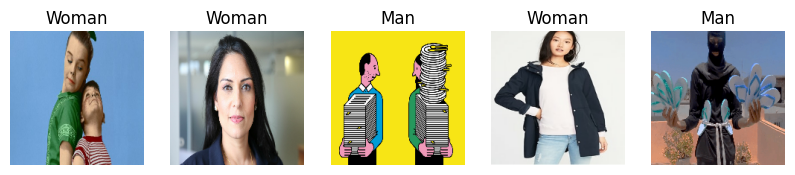

In [ ]:
import matplotlib.pyplot as plt

for data_batch, lable_batch in train_dataset:
    print('Data batch shape:', data_batch.shape)
    print('Label batch shape:', lable_batch.shape)

    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 3))
    for i in range(5):
        axes[i].imshow(data_batch[i].numpy().astype('uint8'))
        axes[i].axis('off')
        title = 'Man' if lable_batch[i].numpy() == 0 else 'Woman'
        axes[i].set_title(title)
    break

## Model Design

In [ ]:
from keras import Model, layers, optimizers, callbacks
import keras_hub

### Data Augmentation Model

In [ ]:
from keras import Sequential

data_augmentation_model = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

### Data Augmentation layers and add to the tensorflow datasets

In [ ]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
]

In [ ]:
import tensorflow as tf

# Creates a function that applies them sequentially
def data_augmentation(images, targets):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images, targets

# Maps this function into the dataset
augmented_train_dataset = train_dataset.map(
    data_augmentation, num_parallel_calls=8
)
# Enables prefetching of batches on GPU memory; important for best
# performance
augmented_train_dataset = augmented_train_dataset.prefetch(tf.data.AUTOTUNE)

### Get a pre-trained model

In [ ]:
preprocessor = keras_hub.layers.ImageConverter.from_preset(
    "xception_41_imagenet",
    image_size=(180, 180),
)

In [ ]:
conv_base = keras_hub.models.Backbone.from_preset("xception_41_imagenet")

### Calculate Features from Images

In [ ]:
import numpy as np

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in tqdm(dataset):
        preprocessed_images = preprocessor(images)
        features = conv_base.predict(preprocessed_images, verbose=0)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

In [ ]:
train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

100%|██████████| 13/13 [00:06<00:00,  2.11it/s]


In [ ]:
train_features.shape

(1600, 6, 6, 2048)

### Design the classification Head

In [ ]:
inputs = layers.Input(shape=(6, 6, 2048))
# Averages spatial dimensions to flatten the feature map
x = layers.GlobalAveragePooling2D()(inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 6, 6, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,201 (512.50 KB)

 Trainable params: 131,201 (512.50 KB)

 Non-trainable params: 0 (0.00 B)

### Train the classification head

In [ ]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

my_callbacks = [
    callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]
history1 = model.fit(
    train_features,
    train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=my_callbacks,
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8076 - loss: 0.4141 - val_accuracy: 0.8550 - val_loss: 0.3130
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9049 - loss: 0.2362 - val_accuracy: 0.8675 - val_loss: 0.3018
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9203 - loss: 0.1984 - val_accuracy: 0.8625 - val_loss: 0.3218
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9166 - loss: 0.1768 - val_accuracy: 0.8700 - val_loss: 0.3254
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9541 - loss: 0.1244 - val_accuracy: 0.8650 - val_loss: 0.3392
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9591 - loss: 0.1175 - val_accuracy: 0.8525 - val_loss: 0.3407
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9765 - loss: 0.0824 - val_accuracy: 0.8700 - val_loss: 0.3446
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9770 - loss: 0.0797 - val_accuracy: 0.8575 - val_loss

<Axes: >

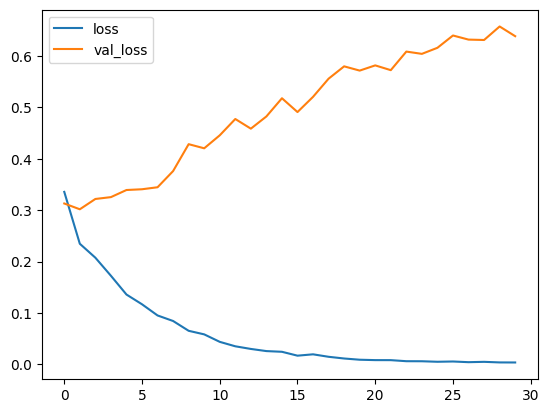

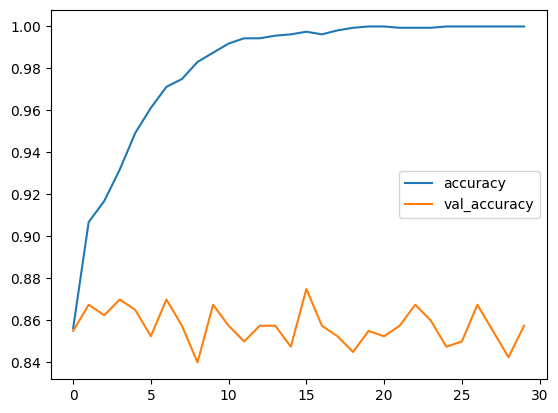

In [ ]:
import pandas as pd

history1_df = pd.DataFrame(history1.history)
history1_df[["loss", "val_loss"]].plot()
history1_df[["accuracy", "val_accuracy"]].plot()

### Evaluate the classification head

In [ ]:
import keras

In [ ]:
model_loaded = keras.models.load_model("feature_extraction.keras")

In [ ]:
loss, accuracy = model_loaded.evaluate(test_features, test_labels)
print(f"Accuracy: {round(accuracy * 100, 2)}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9052 - loss: 0.2298
Accuracy: 89.38%


## Transfer Learning + Data Augmentation

### Freeze the conv base model

In [ ]:
conv_base.trainable = False

In [ ]:
len(conv_base.trainable_weights)

0

### Model design (method 1)

In [ ]:
inputs = layers.Input(shape=(180, 180, 3))
x = data_augmentation_model(inputs)
x = preprocessor(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs, outputs)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ image_converter                 │ (None, 180, 180, 3)    │             0 │
│ (ImageConverter)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception_backbone               │ (None, 6, 6, 2048)     │    20,861,480 │
│ (XceptionBackbone)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,992,681 (80.08 MB)

 Trainable params: 131,201 (512.50 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

### Model Design (method 2)

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = preprocessor(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64)(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ image_converter                 │ (None, 180, 180, 3)    │             0 │
│ (ImageConverter)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception_backbone               │ (None, 6, 6, 2048)     │    20,861,480 │
│ (XceptionBackbone)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,992,681 (80.08 MB)

 Trainable params: 131,201 (512.50 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

### Training (Step 2)
Only the classification head

In [ ]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
)

In [ ]:
my_callbacks = [
    callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]

In [ ]:
history2 = model.fit(
    augmented_train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=my_callbacks,
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 773ms/step - accuracy: 0.7033 - loss: 0.5742 - val_accuracy: 0.8500 - val_loss: 0.3646
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 833ms/step - accuracy: 0.8548 - loss: 0.3763 - val_accuracy: 0.8575 - val_loss: 0.3578
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 855ms/step - accuracy: 0.8704 - loss: 0.3075 - val_accuracy: 0.8700 - val_loss: 0.3194
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 848ms/step - accuracy: 0.8756 - loss: 0.2994 - val_accuracy: 0.8725 - val_loss: 0.3442
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 828ms/step - accuracy: 0.8832 - loss: 0.2785 - val_accuracy: 0.8675 - val_loss: 0.3284
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 826ms/step - accuracy: 0.8809 - loss: 0.2940 - val_accuracy: 0.8550 - val_loss: 0.3410
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 825ms/step - accuracy: 0.8873 - loss: 0.2683 - val_accuracy: 0.8700 - val_loss: 0.3322
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 798ms/step - accuracy: 0.8852 - loss: 0.2703 - val_accu

<Axes: >

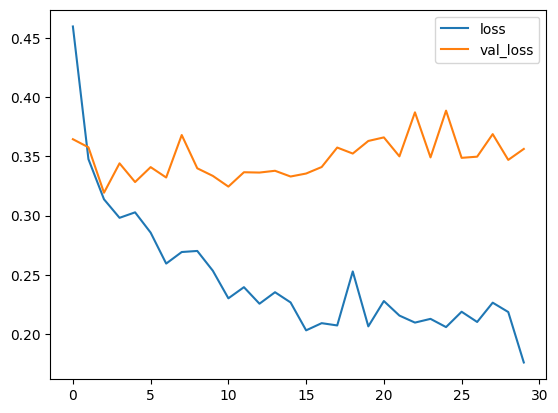

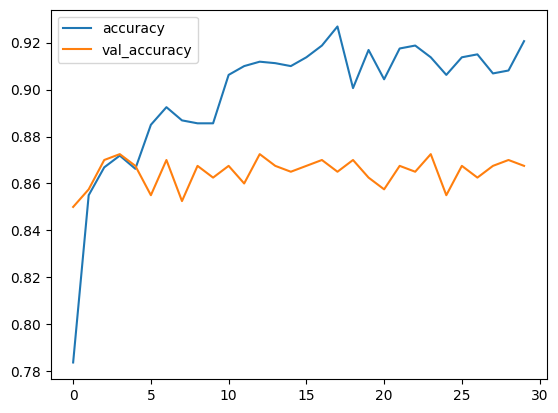

In [ ]:
history2_df = pd.DataFrame(history2.history)
history2_df[["loss", "val_loss"]].plot()
history2_df[["accuracy", "val_accuracy"]].plot()

In [ ]:
model_loaded = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras"
)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 318 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
loss, accuracy = model_loaded.evaluate(test_dataset)
print(f"Accuracy: {round(accuracy * 100, 2)}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 496ms/step - accuracy: 0.8990 - loss: 0.2499
Accuracy: 89.38%


### Training (Step 2)
Un-freeze last 4 layers of the conv_base model

In [ ]:
conv_base.save('conv_base.keras')

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
len(conv_base.trainable_weights)

4

In [ ]:
len(model.trainable_weights)

8

In [ ]:
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss",
    )
]
history3 = model.fit(
    augmented_train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks,
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 846ms/step - accuracy: 0.9309 - loss: 0.2146 - val_accuracy: 0.8675 - val_loss: 0.3536
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 866ms/step - accuracy: 0.9116 - loss: 0.2207 - val_accuracy: 0.8700 - val_loss: 0.3461
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 879ms/step - accuracy: 0.9268 - loss: 0.2144 - val_accuracy: 0.8725 - val_loss: 0.3440
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 878ms/step - accuracy: 0.9266 - loss: 0.1901 - val_accuracy: 0.8650 - val_loss: 0.3413
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 841ms/step - accuracy: 0.9265 - loss: 0.1821 - val_accuracy: 0.8725 - val_loss: 0.3412
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 818ms/step - accuracy: 0.9277 - loss: 0.1857 - val_accuracy: 0.8750 - val_loss: 0.3429
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 867ms/step - accuracy: 0.9405 - loss: 0.1698 - val_accuracy: 0.8800 - val_loss: 0.3428
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 844ms/step - accuracy: 0.9280 - loss: 0.1833 - val_accu

<Axes: >

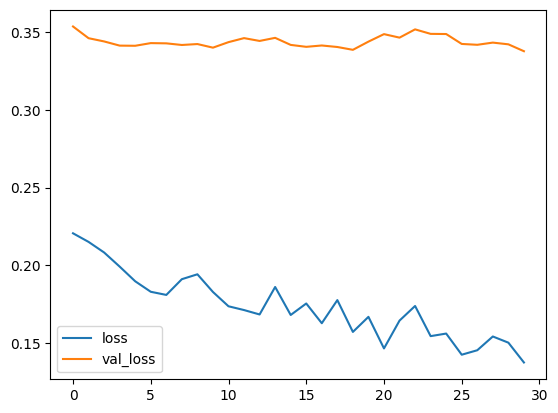

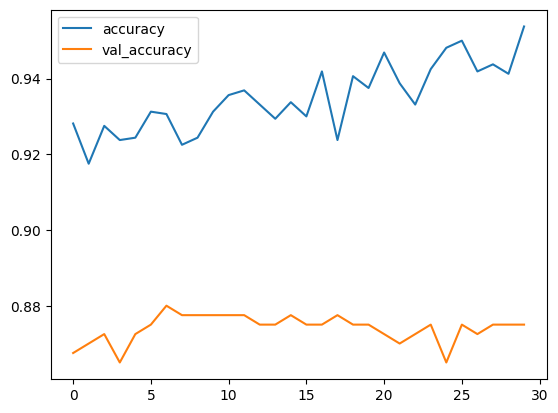

In [ ]:
history3_df = pd.DataFrame(history3.history)
history3_df[["loss", "val_loss"]].plot()
history3_df[["accuracy", "val_accuracy"]].plot()

In [ ]:
model_loaded = keras.models.load_model("fine_tuning.keras")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 318 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
loss, accuracy = model_loaded.evaluate(test_dataset)
print(f"Accuracy: {round(accuracy * 100, 2)}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 568ms/step - accuracy: 0.8878 - loss: 0.2576
Accuracy: 90.13%


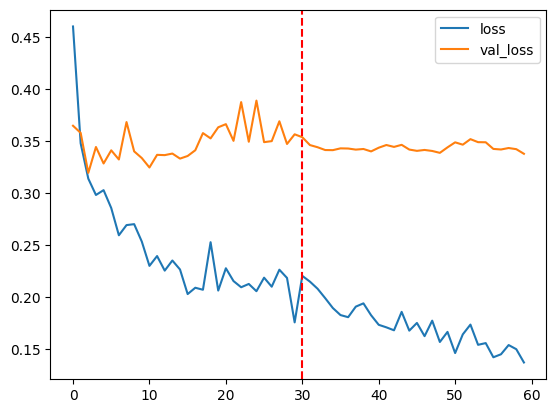

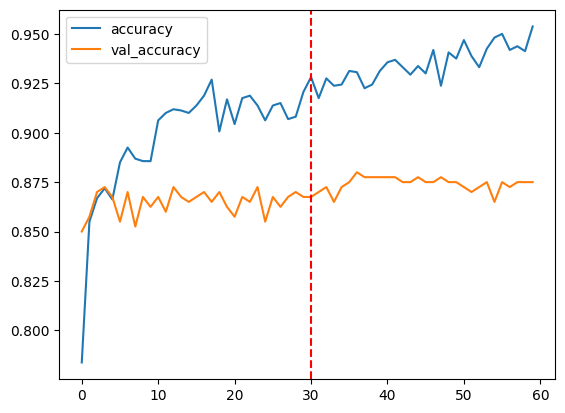

In [ ]:
import matplotlib.pyplot as plt
history_df_combined = pd.concat([history2_df, history3_df],
                                ignore_index=True)
history_df_combined[["loss", "val_loss"]].plot()
plt.axvline(x=30, color='r', linestyle='--')
history_df_combined[["accuracy", "val_accuracy"]].plot()
plt.axvline(x=30, color='r', linestyle='--')
plt.show()

## Save the model in Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/fine_tuning.keras /content/drive/MyDrive